In [87]:
import pandas as pd
import numpy as np
from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
import matplotlib.pyplot as plt
from joblib import dump, load
from geopy.geocoders import Nominatim

In [88]:
df = pd.read_csv('train.csv')

In [89]:
df.head()

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
0,6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,...,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
1,6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,...,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
2,7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,...,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
3,13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,...,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
4,3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,...,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74111 entries, 0 to 74110
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      74111 non-null  int64  
 1   log_price               74111 non-null  float64
 2   property_type           74111 non-null  object 
 3   room_type               74111 non-null  object 
 4   amenities               74111 non-null  object 
 5   accommodates            74111 non-null  int64  
 6   bathrooms               73911 non-null  float64
 7   bed_type                74111 non-null  object 
 8   cancellation_policy     74111 non-null  object 
 9   cleaning_fee            74111 non-null  bool   
 10  city                    74111 non-null  object 
 11  description             74111 non-null  object 
 12  first_review            58247 non-null  object 
 13  host_has_profile_pic    73923 non-null  object 
 14  host_identity_verified  73923 non-null

In [123]:
def fill_zip(df):
    geolocator = Nominatim(user_agent="airbnb_predictor")
    for i in range(0, len(df['zipcode'])):
        if not(len(str(df['zipcode'][i])) == 5):
            location = geolocator.reverse((df['latitude'][i], df['longitude'][i]))
            if 'postcode' in location.raw['address']:
                df['zipcode'][i] = location.raw['address']['postcode'][:5]
            else:
                df['zipcode'][i] = np.NaN

In [124]:
fill_zip(df)

<ipython-input-123-2885546a046d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zipcode'][i] = location.raw['address']['postcode'][:5]
<ipython-input-123-2885546a046d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['zipcode'][i] = np.NaN


In [139]:
df[df['zipcode'].isna()]

,id,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,...,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
251,18125983,5.521461,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,strict,True,...,34.017454,-118.818103,Cozy Cottage across from the Beach,Malibu,36,99.0,https://a0.muscache.com/im/pictures/107125853/...,NaN,1.0,1.0
429,8741446,4.859812,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",3,1.0,Real Bed,strict,True,...,42.355478,-71.058088,Chic 1BR in Downtown Boston,Downtown Crossing,15,94.0,https://a0.muscache.com/im/pictures/6353b8e7-e...,NaN,1.0,2.0
449,17384804,4.905275,Apartment,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,moderate,True,...,40.804206,-73.943019,Great Studio in the heart of Harlem,Harlem,135,93.0,https://a0.muscache.com/im/pictures/c758765b-b...,NaN,0.0,1.0
2615,8485057,5.480639,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",8,2.5,Real Bed,strict,True,...,34.112518,-118.337595,HUGE 3+3 VIEWS 2200sf Hollywood Hts,Hollywood Hills,30,92.0,https://a0.muscache.com/im/pictures/23924433/5...,NaN,3.0,3.0
3061,2927781,4.682131,Condominium,Entire home/apt,"{TV,Internet,""Wireless Internet"",Kitchen,Heati...",2,1.0,Real Bed,strict,True,...,37.763559,-122.445390,"Serene, soaring views, near Haight",Haight-Ashbury,4,95.0,https://a0.muscache.com/im/pictures/22677483/6...,NaN,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51071,16040801,4.595120,Apartment,Entire home/apt,"{Internet,""Wireless Internet"",""Air conditionin...",3,1.0,Real Bed,strict,True,...,40.685258,-73.971541,Bright Private Apartment w/ Manhattan Views,Fort Greene,9,88.0,https://a0.muscache.com/im/pictures/54583374/f...,NaN,1.0,2.0
51243,9367337,5.111988,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,strict,True,...,34.101330,-118.325859,Amazing W Hollywood studio w/ view!,NaN,0,NaN,https://a0.muscache.com/im/pictures/fc9e0915-6...,NaN,0.0,2.0
51534,160597,5.616771,Condominium,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",2,1.0,Real Bed,moderate,False,...,42.359945,-71.062060,"Beacon Hill, Boston",Beacon Hill,19,100.0,https://a0.muscache.com/im/pictures/b7275772-3...,NaN,1.0,1.0
51808,9586718,5.655992,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,strict,True,...,40.730031,-73.990658,1 BR apt in best neighborhood with lots of light,East Village,1,100.0,NaN,NaN,1.0,1.0


In [197]:
def clean(data_frame):
    temp_df = data_frame.copy()
    temp_df.drop('id', axis=1, inplace=True)
    temp_df.drop('amenities', axis=1, inplace=True)
    temp_df.drop('name', axis=1, inplace=True)
    temp_df.drop('neighbourhood', axis=1, inplace=True)
    temp_df.drop('thumbnail_url', axis=1, inplace=True)
    temp_df.drop('description', axis=1, inplace=True)
    temp_df.drop('host_has_profile_pic', axis=1, inplace=True)
    temp_df.drop('host_identity_verified', axis=1, inplace=True)
    temp_df.drop('host_response_rate', axis=1, inplace=True)
    temp_df.drop('host_since', axis=1, inplace=True)
    temp_df.drop('first_review', axis=1, inplace=True)
    temp_df.drop('last_review', axis=1, inplace=True)
    temp_df.drop('latitude', axis=1, inplace=True)
    temp_df.drop('longitude', axis=1, inplace=True)
    temp_df.drop('number_of_reviews', axis=1, inplace=True)
    temp_df.drop('beds', axis=1, inplace=True)
    temp_df.drop('cancellation_policy', axis=1, inplace=True)
    temp_df.drop('cleaning_fee', axis=1, inplace=True)
    temp_df.drop('review_scores_rating', axis=1, inplace=True)
    temp_df.drop('instant_bookable', axis=1, inplace=True)
    temp_df.drop('bed_type', axis=1, inplace=True)
    temp_df.drop('city', axis=1, inplace=True)
    temp_df['price'] = temp_df['log_price'].apply(lambda x: np.exp(x))
    temp_df.drop('log_price', axis=1, inplace=True)
    temp_df = temp_df[temp_df['zipcode'].notna()]
    temp_df['zipcode'] = temp_df['zipcode'].astype(int)
    
    return temp_df

In [198]:
clean_df = clean(df)

In [199]:
clean_df.head()

,property_type,room_type,accommodates,bathrooms,zipcode,bedrooms,price
0,Apartment,Entire home/apt,3,1.0,11201,1.0,150.0
1,Apartment,Entire home/apt,7,1.0,10019,3.0,169.0
2,Apartment,Entire home/apt,5,1.0,10027,1.0,145.0
3,House,Entire home/apt,4,1.0,94143,2.0,750.0
4,Apartment,Entire home/apt,2,1.0,20009,0.0,115.0


In [200]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73972 entries, 0 to 74110
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   property_type  73972 non-null  object 
 1   room_type      73972 non-null  object 
 2   accommodates   73972 non-null  int64  
 3   bathrooms      73773 non-null  float64
 4   zipcode        73972 non-null  int64  
 5   bedrooms       73881 non-null  float64
 6   price          73972 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 4.5+ MB


In [201]:
clean_df['room_type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [202]:
X = clean_df.drop('price', axis=1)
y = clean_df['price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11)

In [178]:
forest_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestRegressor(random_state=11, n_jobs=8)
)

In [179]:
modifiers = {
    'randomforestregressor__max_depth' : range(5, 101, 10),
    'randomforestregressor__n_estimators' : range(50, 401, 50),
    'randomforestregressor__max_samples' : np.arange(0.1, 1, 0.1)
}

gs_model = GridSearchCV(forest_model, param_grid=modifiers, cv=5, n_jobs=8, verbose=1)

In [180]:
gs_model.fit(X_train, y_train)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    9.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:  3.9min
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed: 10.7min
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed: 21.0min
/home/cswizard/.local/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed: 35.3min
[Parallel(n_jobs=8)]: Done 2434 tasks      | elapsed: 50.9min
[Parallel(n_jobs=8)]: Done 3184 tasks      | elapsed: 69.3min
[Parallel(n_jobs=8)]: Done 3600 out of 3600 | elapsed: 80.3min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('ordinalencoder', OrdinalEncoder()),
                                       ('simpleimputer',
                                        SimpleImputer(strategy='most_frequent')),
                                       ('randomforestregressor',
                                        RandomForestRegressor(n_jobs=8,
                                                              random_state=11))]),
             n_jobs=8,
             param_grid={'randomforestregressor__max_depth': range(5, 101, 10),
                         'randomforestregressor__max_samples': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'randomforestregressor__n_estimators': range(50, 401, 50)},
             verbose=1)

In [181]:
gs_model.best_score_

0.49842460492934004

In [182]:
gs_model.best_params_

{'randomforestregressor__max_depth': 25,
 'randomforestregressor__max_samples': 0.1,
 'randomforestregressor__n_estimators': 350}

In [203]:
model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='most_frequent'),
    RandomForestRegressor(random_state=11, n_jobs=8, max_depth=10, max_samples=0.3, n_estimators=320)
)

In [204]:
model.fit(X_train, y_train);

In [205]:
model.named_steps['randomforestregressor'].feature_importances_

array([0.03530041, 0.10475276, 0.07617685, 0.23589784, 0.19738334,
       0.35048879])

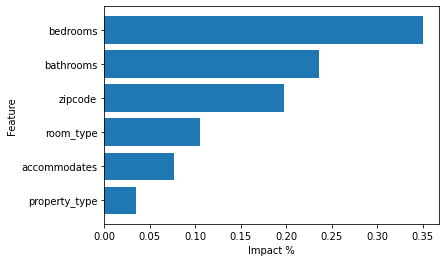

In [206]:
top = pd.Series(model.named_steps['randomforestregressor'].feature_importances_, index=model.named_steps['ordinalencoder'].get_feature_names())
top_ten = top.sort_values(key=(lambda x:abs(x))).tail(13)

plt.barh(top_ten.index, top_ten)
plt.xlabel('Impact %')
plt.ylabel('Feature')
plt.show()

In [207]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

print('Train MAE:', mean_absolute_error(y_train, model.predict(X_train)))
print('Train RMSE:', mean_squared_error(y_train, model.predict(X_train), squared=False))

Train MAE: 56.827576490991866
Train RMSE: 112.4029737181027


In [208]:
print('Val MAE:', mean_absolute_error(y_val, model.predict(X_val)))
print('Val RMSE:', mean_squared_error(y_val, model.predict(X_val), squared=False))

Val MAE: 58.31713430759482
Val RMSE: 117.99140881451045


In [195]:
baseline = mean_absolute_error(y, [y.mean() for i in range(0, len(y))])
print(baseline)

97.6868811250671


In [211]:
model.score(X_val, y_val)

0.47844283161811785

In [212]:
dump(model, 'model.joblib')

['model.joblib']